<a href="https://colab.research.google.com/github/JTT94/neural_processes/blob/valerie-working/NeuralProcess_vb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ExpSineSquared

# import functions 
from functions import *
from nn_architecture import *
from NeuralProcess import *

# Neural Processes

Goal: Combine benefits of Gaussian processes (distribution over functions) and neural networks (flexibility, no assumption of kernel type)

Replicating work from Kaspar Martens' [blog post](https://kasparmartens.rbind.io/post/np/) on Neural Processes with help translating to Python from Sander van Dijk's [GitHub repo](https://github.com/sgvandijk/neural-processes).


## Demonstrate Gaussian Process regression

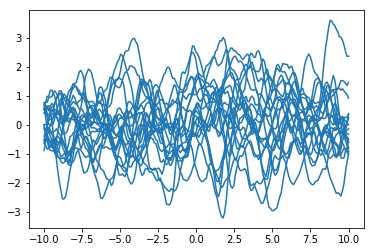

In [14]:
# generate data from GP

# intialize GP with Matern kernel
gp = GaussianProcessRegressor(Matern())

# generate Xs
xs = np.linspace(-10,10,200)

# sample from GP
y_samples = gp.sample_y(xs.reshape((-1, 1)), n_samples = 20, random_state=11)

#plot samples
ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(y_samples.shape[1]):
  plt.plot(xs, y_samples[:,i], alpha = 1, c = ccycle[0])

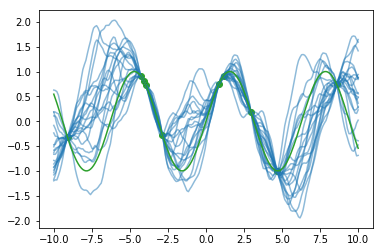

In [15]:
# GP regression
x_ind = random.sample(set(range(xs.shape[0])), 10)
x_context = xs[x_ind]

# fit GP on context points
y_true = np.sin(x_context)

gp.fit(x_context.reshape((-1, 1)), y_true)

#sample new points from fitted GP
y_samples_new = gp.sample_y(xs.reshape((-1, 1)), n_samples=20, random_state=12)


#plot samples
#ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(y_samples_new.shape[1]):
  plt.plot(xs, y_samples_new[:,i], alpha = 0.5, c = ccycle[0])

plt.scatter(x_context, y_true, alpha = 1, c = ccycle[2])
plt.plot(xs, np.sin(xs), c = ccycle[2])
plt.show()

## NP as a prior over functions

In [20]:
params = NeuralProcessParams(dim_r = 10, dim_z = 7, n_hidden_units_h = [3], n_hidden_units_g = [10])

from functions import get_context_target

x_context, y_context, x_target, y_target = get_context_target(xs, y_samples, n_context = 10)


ImportError: cannot import name 'get_context_target' from 'functions' (/Users/valeriebradley/github/neural_processes/experiments/valerie/functions.py)

## Walk through steps of NP


In [0]:
#specify params



# set context placeholders
x_context = tf.placeholder(tf.float32, shape = (None, 1))
y_context = tf.placeholder(tf.float32, shape = (None, 1))
x_target = tf.placeholder(tf.float32, shape = (None, 1))
y_target = tf.placeholder(tf.float32, shape = (None, 1))

x_all = tf.concat([x_context, x_target], axis = 0)  #shape: [? + ?, 1]
y_all = tf.concat([y_context, y_target], axis = 0)  #shape: [? + ?, 1]

xys_context = tf.concat([x_context, y_context], axis = 1)   #shape: [?, 2]  form (x_i, y_i) pair to map to latent r_i


#steps
rs = encoder_h(xys_context, params)    #shape: [?, dim_r]
r = aggregate_r(rs)                    #shape: [1, dim_r]
z_params = get_z_params(r, params)     #shape: mu = [1, dim_z], sigma = [1, dim_z]

# do them all together
z_params_all = map_xy_to_z(x_all, y_all, params)   #shape: mu = [1, dim_z], sigma = [1, dim_z]
z_params_context = map_xy_to_z(x_context, y_context, params)

#sample from params
epsilon = tf.random_normal(shape = [5, params.dim_z])
z_samples = tf.multiply(epsilon, z_params_all.sigma)
z_samples = tf.add(z_samples, z_params_all.mu)

#run decoder
y_pred_params = decoder_g(z_samples, x_target, params, noise_std = 0.05)




In [0]:
getKLdist(z_params_all.mu, z_params_all.sigma, z_params_context.mu, z_params_context)

<tf.Tensor 'mul_15:0' shape=() dtype=float32>

In [0]:
# define function to get context and target sets



#generate context and target sets




array([[ 0.85008851,  0.09487572, -0.53470948, -0.01638847,  0.5196182 ,
         0.19871517,  1.54483728, -0.45093634,  0.01896444, -0.69426228,
        -0.49642261, -0.42772611, -0.94423295, -0.24856352, -1.17620471,
         0.83835573,  0.10844581, -1.51418394, -0.06788754,  0.61181988],
       [-0.99976191, -0.21580115,  0.01609198, -0.7880319 , -0.61563878,
         1.13874052, -0.23495491, -1.40946883, -0.20873526,  0.76689181,
         0.94181789,  0.94661334, -0.78649774,  1.22395545,  0.35756501,
         1.56381252, -0.76405228, -1.17422382, -0.48684811,  0.35036031],
       [-0.50889323, -1.03805853, -0.5695944 , -0.72379194,  0.5349586 ,
        -1.90378494,  1.83134566, -0.45543647, -0.42191754,  0.10046235,
         0.907733  , -0.48121379,  0.3658422 , -1.8824819 ,  0.41085146,
         1.18646284, -0.21120631,  0.83445375, -0.48576044,  0.35911178],
       [ 0.23694223, -0.52668246, -0.29375975, -0.12148884,  0.88865051,
        -0.99415033,  1.79996227,  0.1987098 , -

In [0]:
x_context

array([-9.69849246, -2.36180905,  3.66834171, -2.16080402, -3.76884422,
        7.68844221,  3.16582915,  8.69346734,  2.16080402, -6.08040201])